In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary


In [13]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
# Load MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
# Add noise to images
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)


In [17]:
# Define Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(DenoisingAutoencoder, self).__init__()
        # Define your layers here
        # Example:
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # For reconstruction, sigmoid is often used
        )
    def forward(self, x):
        # Include your code here
        x = x.view(-1, 28*28)  # Flatten the input image
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return x

In [18]:
#Initialize model, loss function and optimizer
model = DenoisingAutoencoder().to(device)
summary(model, (1, 28, 28))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [19]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [20]:
# Train the autoencoder
def train(model, loader, criterion, optimizer, epochs=5):
    # Include your code here
    model.train() # Set the model to training mode
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(device)
            noisy_data = add_noise(data)  # Add noise to the input data
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = criterion(output, data)  # Calculate loss
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(loader)}], Loss: {loss.item():.4f}')


In [21]:
# Evaluate and visualize
def visualize_denoising(model, loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name: DAKSHA SUBBAIAN")
    print("Register Number: 212223230036")
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/5], Step [1/469], Loss: 0.2314
Epoch [1/5], Step [101/469], Loss: 0.0682
Epoch [1/5], Step [201/469], Loss: 0.0686
Epoch [1/5], Step [301/469], Loss: 0.0626
Epoch [1/5], Step [401/469], Loss: 0.0591
Epoch [2/5], Step [1/469], Loss: 0.0612
Epoch [2/5], Step [101/469], Loss: 0.0564
Epoch [2/5], Step [201/469], Loss: 0.0550
Epoch [2/5], Step [301/469], Loss: 0.0490
Epoch [2/5], Step [401/469], Loss: 0.0522
Epoch [3/5], Step [1/469], Loss: 0.0442
Epoch [3/5], Step [101/469], Loss: 0.0456
Epoch [3/5], Step [201/469], Loss: 0.0484
Epoch [3/5], Step [301/469], Loss: 0.0438
Epoch [3/5], Step [401/469], Loss: 0.0446
Epoch [4/5], Step [1/469], Loss: 0.0431
Epoch [4/5], Step [101/469], Loss: 0.0429
Epoch [4/5], Step [201/469], Loss: 0.0441
Epoch [4/5], Step [301/469], Loss: 0.0423
Epoch [4/5], Step [401/469], Loss: 0.0450
Epoch [5/5], Step [1/469], Loss: 0.0423
Epoch [5/5], Step [101/469], Loss: 0.0429
Epoch [5/5], Step [201/469], Loss: 0.0435
Epoch [5/5], Step [301/469], Loss: 0.0410
Ep

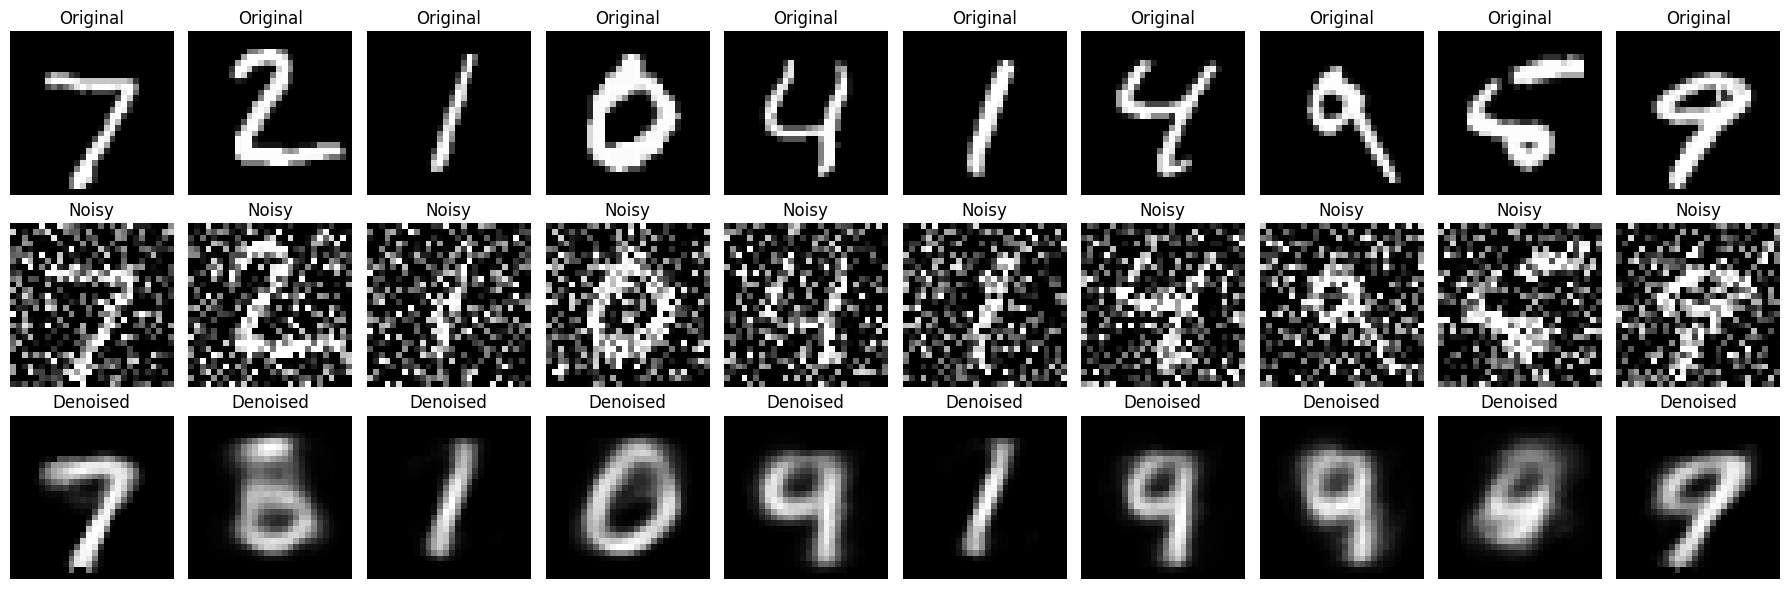

In [22]:
# Run training and visualization
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)